# Introduction

If you’ve explored lattice-based cryptography, you’ve likely come across the concept of the smoothing parameter. In this post, we’ll take a step-by-step approach to "reverse engineer" this important lattice parameter. Our goal is to build a solid intuition for it—grounded in mathematical foundations, of course! 😊

One of the most remarkable aspects of lattice-based cryptography is the worst-case to average-case reduction security proof. Here's the idea: when we instantiate a lattice-based cryptosystem, we generate elements like secret keys, noise, etc., at random. If we assume that an attacker cannot solve the underlying mathematical problem when the instance of that problem is chosen at random, we say the system has average-case security. In lattice-based cryptography, we go beyond mere assumptions. We can rigorously prove that solving the average-case instance of certain lattice problems is at least as hard as solving the worst-case instance of another lattice problem. In other words, if an attacker can break a random instance of the problem, they can also solve the hardest instances of the related problem. This significantly strengthens our confidence in the security of lattice-based cryptography.

We start our journey from the following big picture: in many security proof in the lattice world we need the following structure:
1. Chose a lattice point.
2. Randomly generate a noise vector.
3. Add the noise with the lattice point and reduce the result mod fundamental domain.

Consider the following example in $\mathbb{R}^2$ where the chosen lattice point is the green point, the noise is the red vector, the result of the addition is the blue point and the result of the reduction mod the fundamental domain (hashed area) is the 'x' point. 

Let's introduce some notations for the sake of completness:

1. $L$ is the lattice.
2. $B \in \mathbb{R}^{n \times n}$ is the base of the lattice $L$.
2. $\mathcal{P}(B)$ is the fundamental domain. 

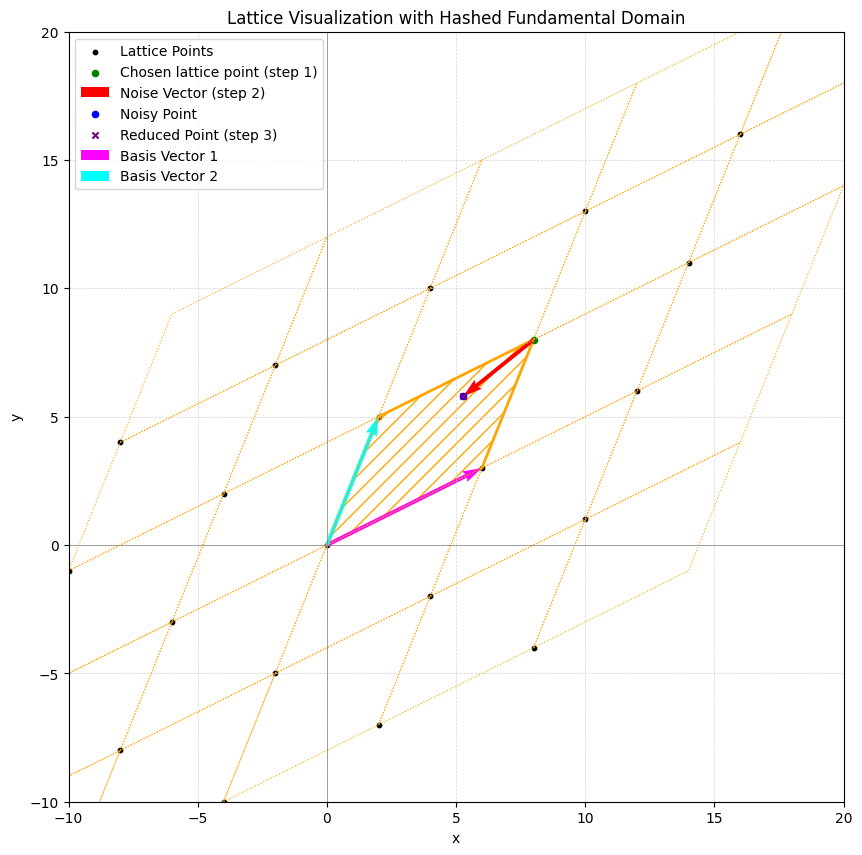

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Function to generate lattice points
def generate_lattice(basis, x_range, y_range):
    points = []
    for i in range(x_range[0], x_range[1]):
        for j in range(y_range[0], y_range[1]):
            point = i * basis[:, 0] + j * basis[:, 1]
            points.append(point)
    return np.array(points)

# Function to reduce a point modulo the fundamental domain
def reduce_mod_basis(point, basis):
    inv_basis = np.linalg.inv(basis)
    coeffs = np.dot(inv_basis, point)
    coeffs = coeffs - np.floor(coeffs) # Reduce coefficients mod 1
    return np.dot(basis, coeffs)

# Define the lattice basis (2D) with larger vectors
basis = np.array([[6, 2], [3, 5]])

# Generate lattice points
lattice_points = generate_lattice(basis, x_range=(-2, 3), y_range=(-2, 3))

# Select a lattice point (green dot)
lattice_point = 1 * basis[:, 0] + 1 * basis[:, 1] # Example: (1, 1) in lattice coordinates

# Add noise (larger random vector)
noise = np.random.uniform(-5, 5, size=2) # Larger noise
noisy_point = lattice_point + noise

# Reduce modulo the fundamental domain
reduced_point = reduce_mod_basis(noisy_point, basis)

# Plot the lattice
plt.figure(figsize=(10, 10))
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], color='black', s=10, label='Lattice Points')

# Plot all parallelograms in the lattice
for point in lattice_points:
    parallelogram = np.array([
        point,
        point + basis[:, 0],
        point + basis[:, 0] + basis[:, 1],
        point + basis[:, 1],
        point
    ])
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], color='orange', linestyle='dotted', linewidth=0.8)

# Highlight the fundamental domain (parallelogram at the origin) with a hashed pattern
fundamental_parallelogram = np.array([
    [0, 0],
    basis[:, 0],
    basis[:, 0] + basis[:, 1],
    basis[:, 1],
    [0, 0]
])
polygon = Polygon(fundamental_parallelogram, closed=True, facecolor='none', edgecolor='orange', hatch='//', linewidth=2)
plt.gca().add_patch(polygon)

# Plot the lattice point (green dot)
plt.scatter(lattice_point[0], lattice_point[1], color='green', s=20, label='Chosen lattice point (step 1)')

# Plot the noise vector (larger arrow)
plt.quiver(
    lattice_point[0], lattice_point[1], noise[0], noise[1],
    angles='xy', scale_units='xy', scale=1, color='red', width=0.005, label='Noise Vector (step 2)'
)

# Plot the noisy point
plt.scatter(noisy_point[0], noisy_point[1], color='blue', s=20, label='Noisy Point')

# Plot the reduced point
plt.scatter(reduced_point[0], reduced_point[1], color='purple', s=20, marker='x', label='Reduced Point (step 3)')

# Mark the basis vectors
plt.quiver(
    0, 0, basis[0, 0], basis[1, 0],
    angles='xy', scale_units='xy', scale=1, color='magenta', width=0.005, label='Basis Vector 1'
)
plt.quiver(
    0, 0, basis[0, 1], basis[1, 1],
    angles='xy', scale_units='xy', scale=1, color='cyan', width=0.005, label='Basis Vector 2'
)

# Add labels and legend
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Lattice Visualization with Hashed Fundamental Domain')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Zoom in on a smaller region of the lattice
plt.axis('auto')
plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()


Now, we do have some constrains:

1. We want the expected norm of such the error vector to be a particular number, called it $s$.
2. As all good things in cryptography, we want the result of the reduction to appear as chosen from an uniform distribution. 

Why we want this to happen? Well this is a story for another article :-) 

Maybe one just thinks - ok, if we want to generate vectors that appear as sample from a uniform distribution let's just sample each coordinate from a uniform distribution. This works like a charm for the second property but sampling each coordinate from a uniform distribution will take us quite far from the first goal. 

If we concentrate on the first property, one solution to generate vectors with expected norm $s$ is to sample each coordinate from a Gaussian distribution with a standard deviation of $s/\sqrt{n}$ where $n$ is the number of coordinates. But now, what about the "uniform"-like appearance? 

Let's build some intuition: a lattice has an obvious periodic structure. When we look at the image above, we see  one cell (the fundamental domain) repeated over and over again. Now, by endesly repeating this cell we cover the entire space. This means that each point in the space can be written as the sum between a point in the fundamental domain and some lattice point. From another perspective, if we keep translating the fundamental domain by lattice points we cover the entire space which means that all points can be written as the sum between a lattice point and a point from within the cell. This is ilustrated in the figure from below and more formally:

$$ w = t + v,\text{for a unique}\ t\ \in \mathcal{P}(B)\ \text{and a unique}\ v \in L$$







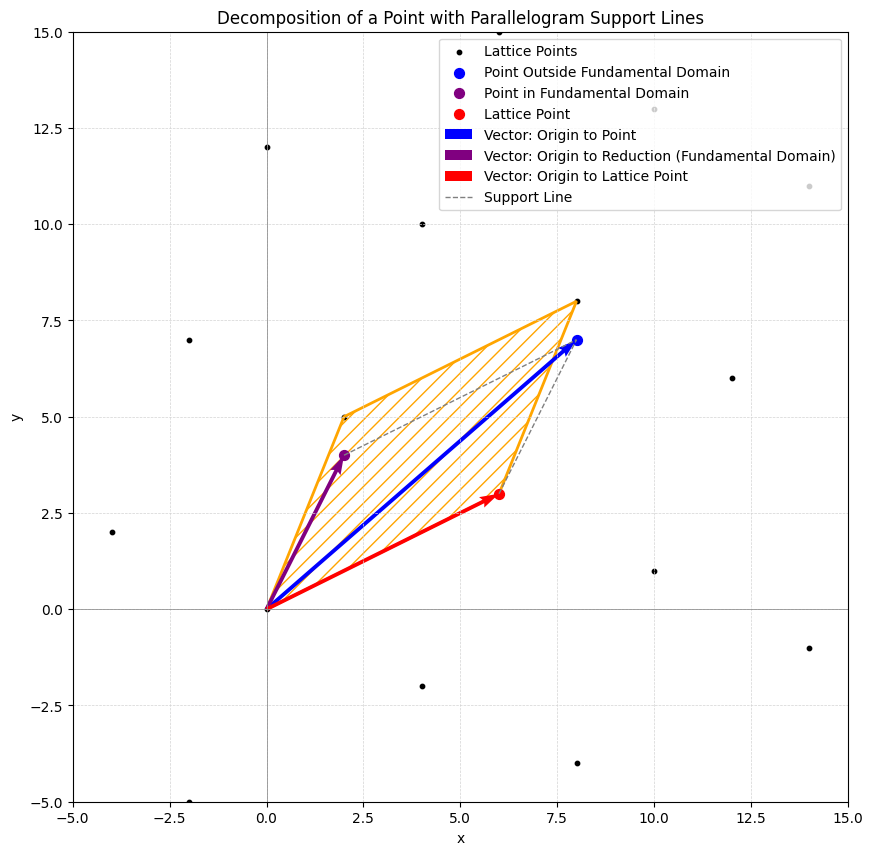

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Function to generate lattice points
def generate_lattice(basis, x_range, y_range):
    points = []
    for i in range(x_range[0], x_range[1]):
        for j in range(y_range[0], y_range[1]):
            point = i * basis[:, 0] + j * basis[:, 1]
            points.append(point)
    return np.array(points)

# Function to reduce a point modulo the fundamental domain
def reduce_mod_basis(point, basis):
    inv_basis = np.linalg.inv(basis)
    coeffs = np.dot(inv_basis, point)
    lattice_point = np.dot(basis, np.floor(coeffs))  # Lattice point
    fundamental_point = point - lattice_point       # Point in the fundamental domain
    return fundamental_point, lattice_point

# Define the lattice basis (2D)
basis = np.array([[6, 2], [3, 5]])

# Generate lattice points
lattice_points = generate_lattice(basis, x_range=(-3, 4), y_range=(-3, 4))

# Define a point closer to the origin
outside_point = np.array([8, 7])  # Example point closer to the origin

# Decompose the point into a fundamental domain point and a lattice point
fundamental_point, lattice_point = reduce_mod_basis(outside_point, basis)

# Plot the lattice
plt.figure(figsize=(10, 10))
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], color='black', s=10, label='Lattice Points')

# Highlight the fundamental domain (parallelogram at the origin)
fundamental_parallelogram = np.array([
    [0, 0],
    basis[:, 0],
    basis[:, 0] + basis[:, 1],
    basis[:, 1],
    [0, 0]
])
polygon = Polygon(fundamental_parallelogram, closed=True, facecolor='none', edgecolor='orange', hatch='//', linewidth=2)
plt.gca().add_patch(polygon)

# Plot the point outside the fundamental domain
plt.scatter(outside_point[0], outside_point[1], color='blue', s=50, label='Point Outside Fundamental Domain')

# Plot the fundamental domain point
plt.scatter(fundamental_point[0], fundamental_point[1], color='purple', s=50, label='Point in Fundamental Domain')

# Plot the lattice point
plt.scatter(lattice_point[0], lattice_point[1], color='red', s=50, label='Lattice Point')

# Draw vector from origin to the outside point
plt.quiver(
    0, 0,
    outside_point[0], outside_point[1],
    angles='xy', scale_units='xy', scale=1, color='blue', width=0.005, label='Vector: Origin to Point'
)

# Draw vector from origin to the fundamental domain point
plt.quiver(
    0, 0,
    fundamental_point[0], fundamental_point[1],
    angles='xy', scale_units='xy', scale=1, color='purple', width=0.005, label='Vector: Origin to Reduction (Fundamental Domain)'
)

# Draw vector from origin to the lattice point
plt.quiver(
    0, 0,
    lattice_point[0], lattice_point[1],
    angles='xy', scale_units='xy', scale=1, color='red', width=0.005, label='Vector: Origin to Lattice Point'
)

# Add support lines to form the parallelogram
# Line from lattice point to the outside point
plt.plot(
    [lattice_point[0], outside_point[0]],
    [lattice_point[1], outside_point[1]],
    color='gray', linestyle='--', linewidth=1, label='Support Line'
)

# Line from fundamental point to the outside point
plt.plot(
    [fundamental_point[0], outside_point[0]],
    [fundamental_point[1], outside_point[1]],
    color='gray', linestyle='--', linewidth=1
)

# Add labels and legend
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Decomposition of a Point with Parallelogram Support Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

# Adjust zoom level for better visualization
plt.axis('auto')
plt.xlim(-5, 15)
plt.ylim(-5, 15)

plt.show()


In a sense, this naturally induces an equivalence relation: we consider two points to be equivalent if they map to the same point in the fundamental domain. In other words, two points are equivalent if they differ by a lattice point.

Now, let’s return to our Gaussian distribution, denoted by $\mathcal{G}_s$ (the probability distribution of vectors with an expected norm $s$). The distribution $\mathcal{G}_s$ assigns a probability density value $\mathcal{G}_s(x)$ to each point $x \in \mathbb{R}^n$. This raises an interesting question:

How does this distribution behave under the equivalence relation defined above?
What is the density value assigned to a point in the fundamental domain?
Recall that for each point in the fundamental domain, there are infinitely many equivalent points in $\mathbb{R}^n$ that differ by lattice vectors. For example, $\mathcal{G}_s$ assigns a density value to a point $t \in \mathcal{P}(B)$ and another density value to each equivalent point $w = t + v$, where $v$ is any lattice vector. However, under the equivalence relation, all these points $w$ are considered "the same" as $t$. So, what should the density value assigned to $t$ be?

A natural way to handle this is to define a new probability distribution, $\mathcal{D}_s$, which is restricted to the fundamental domain. The density value assigned by $\mathcal{D}_s$ to a point $t \in \mathcal{P}(B)$ is the sum of all density values assigned by $\mathcal{G}_s$ to the equivalent points $w = t + v$, for all $v \in L$. Mathematically, this is expressed as:

$$ \mathcal{D}_s(x) = \sum_{z \in L} \mathcal{G}_s(x + z) $$

Let’s revisit our constraints. We aim to sample an error vector from a Gaussian distribution with an expected norm of $s$. However, when this error is reduced to the fundamental domain, we want it to appear as though it was sampled from a uniform distribution. In other words, while the error is initially sampled from $\mathcal{G}_s$, we want the resulting distribution $\mathcal{D}_s$ to be indistinguishable from a uniform distribution.

To better understand this, let’s visualize it using a simple lattice, $\mathbb{Z}$, with the fundamental domain $[0, 1)$. We’ll examine how $\mathcal{D}_s$ behaves for different values of $s$. For small values of $s$ (e.g., $0.1$, $0.2$), $\mathcal{D}_s$ is noticeably different from a uniform distribution (which would appear as a flat line). However, as we increase $s$, something interesting happens: $\mathcal{D}_s$ begins to resemble a uniform distribution, gradually transforming into a flat line.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Gaussian function G_s
def G_s(x, s):
    scale = np.sqrt(2 * np.pi) * s
    return (1 / scale) * np.exp(-np.pi * (x / scale) ** 2)

# Periodic sum D_s over the integer lattice
def D_s(x, s, num_terms=100):
    return sum(G_s(x - z, s) for z in range(-num_terms, num_terms + 1))

# Plotting function for interactive slider
def plot_Gs_Ds(s):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

    # Plot G_s over the real line
    x1 = np.linspace(-4, 4, 1000)
    axs[0].plot(x1, G_s(x1, s), label=f'$G_s$, s={s:.2f}')
    axs[0].set_title("$G_s(x)$ over $\mathbb{R}$")
    axs[0].set_ylabel("$G_s(x)$")
    axs[0].legend()
    axs[0].grid(True)

    # Plot D_s over extended domain to show multiple periods
    x2 = np.linspace(0, 1, 1500)
    y2 = [D_s(val, s) for val in x2]
    axs[1].plot(x2, y2, label=f'$D_s$, s={s:.2f}')
    axs[1].set_title("$D_s(x)$ over $[0, 1]$")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("$D_s(x)$")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Interactive slider for s
interact(plot_Gs_Ds, s=FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description='s'));


interactive(children=(FloatSlider(value=0.2, description='s', max=2.0, min=0.01, step=0.01), Output()), _dom_c…

To summarize the bigger picture: we aim to sample error vectors from a Gaussian distribution to ensure an expected norm of $s$. At the same time, we want the error to appear as if it were sampled from a uniform distribution when reduced modulo the fundamental domain. The intuitive solution to satisfy both requirements is to ensure that the Gaussian distribution is sufficiently wide.

This makes sense intuitively: a Gaussian distribution is characterized by its "hump." When the distribution is wide enough and we map it into a small cell (the fundamental domain), the "hump" effect becomes less noticeable, resulting in a distribution that looks more uniform.

Now we still have one important question to answer: how "wide" is "wide" enough? To answer this quesion we must find a way to measure how "uniform" is $\mathcal{D}_s$. Here is one clue: let's plot $\mathcal{D}_s$ over the entire space.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Gaussian function G_s
def G_s(x, s):
    scale = np.sqrt(2 * np.pi) * s
    return (1 / scale) * np.exp(-np.pi * (x / scale) ** 2)

# Periodic sum D_s over the integer lattice
def D_s(x, s, num_terms=100):
    return sum(G_s(x - z, s) for z in range(-num_terms, num_terms + 1))

# Plotting function for interactive slider
def plot_Gs_Ds(s):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

    # Plot G_s over the real line
    x1 = np.linspace(-4, 4, 1000)
    axs[0].plot(x1, G_s(x1, s), label=f'$G_s$, s={s:.2f}')
    axs[0].set_title("$G_s(x)$ over $\mathbb{R}$")
    axs[0].set_ylabel("$G_s(x)$")
    axs[0].legend()
    axs[0].grid(True)

    # Plot D_s over extended domain to show multiple periods
    x2 = np.linspace(-3, 3, 1500)
    y2 = [D_s(val, s) for val in x2]
    axs[1].plot(x2, y2, label=f'$D_s$, s={s:.2f}')
    axs[1].set_title("$D_s(x)$ over $[-3, 3]$")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("$D_s(x)$")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Interactive slider for s
interact(plot_Gs_Ds, s=FloatSlider(value=0.2, min=0.01, max=2.0, step=0.01, description='s'));


interactive(children=(FloatSlider(value=0.2, description='s', max=2.0, min=0.01, step=0.01), Output()), _dom_c…

Looks a lot like a periodic function. This does not change what we observed about $s$: when as we increase $s$, $\mathcal{D}_s$ becomes more and more uniform. 

This periodicity aspects leads us to think about Fourier.

Consider a "nice" periodic function $f:\mathcal{P}(B) \rightarrow \mathbb{R}$. Why $\mathcal{P}(B)$ and not $\mathbb{R}^n$? Well we just said that the function is periodic over the lattice so we just need to defined it over a single lattice cell. Fourier transform enables us to write the function $f$ as a sum of some periodic basis functions of the form $x \mapsto e^{2\pi i \langle x, y \rangle}$. Let's plot some basis functions or it least what's real about them :-)



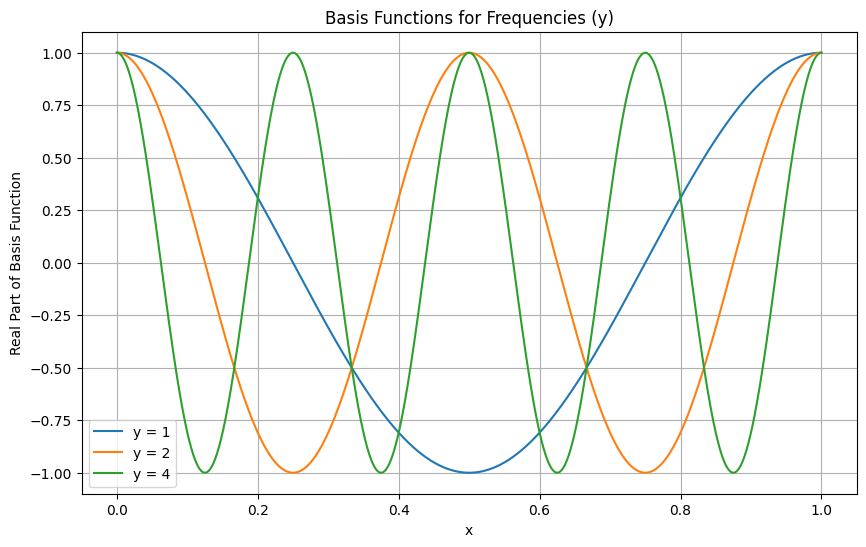

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
x = np.linspace(0, 1, 1000)  # x values from 0 to 1
y_values = [1, 2, 4]  # Different y values

# Plot basis functions
plt.figure(figsize=(10, 6))
for y in y_values:
    basis_function = np.exp(2j * np.pi * y * x)  # Complex exponential
    plt.plot(x, np.real(basis_function), label=f'y = {y}')  # Plot real part

# Customize the plot
plt.title('Basis Functions for Frequencies (y)')
plt.xlabel('x')
plt.ylabel('Real Part of Basis Function')
plt.legend()
plt.grid()
plt.show()


We’ve plotted some basis functions for $y = 1$, $y = 2$, and $y = 4$, but why not try $y = \sqrt{2}$ or $y = 1.5$? What determines the allowed values for the frequencies? The key lies in the periodicity of the basis functions: $e^{2\pi i \langle x, y \rangle} = e^{2\pi i \langle x+v, y \rangle}$, for all $v \in L$. Expanding this, we get $e^{2\pi i \langle x+v, y \rangle} = e^{2\pi i \langle x, y \rangle} e^{2\pi i \langle v, y \rangle}$, which implies $e^{2\pi i \langle v, y \rangle} = 1$. This condition holds when $2\pi i \langle v, y \rangle = 0$, or equivalently, when $\langle v, y \rangle \in \mathbb{Z}$ for all $v \in L$.

In other words, the allowed frequencies are vectors $y \in \mathbb{R}^n$ that have an integer dot product with every point in the lattice $L$. Interestingly, these frequencies themselves form a lattice, known as the dual lattice, denoted by $L^*$.

Let’s return to our function, $f$. It can be expressed as the following sum:

$$ f(x) = \sum_{y \in L^*} \hat{f}(y) e^{2\pi i \langle x, y \rangle}, $$

where the coefficients $\hat{f}(y)$ are given by:

$$ \hat{f}(y) = \frac{1}{\det(L)} \int_{P(B)} f(x) e^{-2\pi i \langle x, y \rangle} , dx. $$

Here, $\hat{f}(y)$ represents the "weight" of the signal $x \mapsto e^{2\pi i \langle x, y \rangle}$ in the decomposition. While this may sound complex, in our case, $f$ is simply the Gaussian distribution of vectors with expected norm $s$, reduced modulo the fundamental domain. More concretely, $f(x) = \mathcal{D}_s(x)$. For this specific function, the Fourier coefficients $\hat{f}(y)$ can be computed easily. Ignoring the constant term $\det(L)$ for simplicity, we have:

$$ \hat{\mathcal{D}}_s(y) = e^{-\pi s^2 | y |^2}. $$

Now, why are we diving into all these formulas? Our goal is to assess how "uniform" $\mathcal{D}_s$ is. Intuitively, if $\mathcal{D}_s$ were concentrated along a single line, we would see a single spike in the frequency domain at $y = 0$, because $\hat{\mathcal{D}}_s(0) = 1$, while all other frequencies would have zero weight. Think of it this way: the purpose of the Fourier transform is to represent a function as a sum of terms. If the function is constant, only one term (the zero frequency) is needed to represent it.

If $\mathcal{D}_s$ were perfectly uniform, we would observe only one non-zero frequency, $y = 0$, with $\hat{\mathcal{D}}_s(0) = 1$. Generalizing this idea, we can define a "uniformity metric" for $\mathcal{D}_s$ as the sum of its Fourier coefficients (excluding $y = 0$). The smaller this sum, the more uniform $\mathcal{D}_s$ is. We denote this sum as:

$$ \rho_{1/s}(L^* \setminus {0}) = \sum_{y \in L^* \setminus {0}} e^{-\pi |y|^2 s^2}. $$

This notation aligns with standard conventions in the literature. To justify it briefly: $\hat{\mathcal{D}}_s$ is a Gaussian function, traditionally denoted by $\rho$, and the sum above represents the Gaussian mass.

Of course, perfect uniformity for $\mathcal{D}_s$ is unattainable. But we’re not chasing perfection—we’re building solid, practical foundations for security. In applications, we aim for $\mathcal{D}_s$ to have a "uniformity metric" $\rho{1/s}(L^* \setminus {0})$ smaller than some chosen threshold $\epsilon$:

$$ \rho_{1/s}(L^* \setminus {0}) < \epsilon. $$

Let’s circle back to our motivation: we wanted to sample an error vector with a specific norm that looks uniformly distributed when reduced modulo the fundamental domain. The solution? Sample the vector from a Gaussian distribution $\mathcal{G}_s$ and then reduce it to the fundamental domain. We observed that as the standard deviation $s$ increases, the reduced distribution becomes increasingly uniform. To quantify this uniformity, we introduced the metric $\rho_{1/s}(L^* \setminus {0})$.

Now for the final piece: the smoothing parameter of a lattice, denoted by $\eta_{\epsilon}(L)$, is defined as the smallest $s$ such that:

$$ \rho_{1/s}(L^* \setminus {0}) < \epsilon. $$

In this article, we’ve built some intuition around the smoothing parameter. But the real magic lies in how Regev used this concept in one of the most groundbreaking security reductions in lattice-based cryptography. Here’s a hint: it involves the shortest vector problem on the dual lattice. Intrigued? Stay tuned for the next chapter of this fascinating story.

<sub><i>Disclaimer: This python code was generated by GenAI.</i></sub>


# Resources 

[Lattices Part II — Dual Lattices, Fourier Transform, Smoothing Parameter, Public Key Encryption](https://www.cs.princeton.edu/courses/archive/spr08/cos598D/lattices.pdf)

[Worst-case to Average-case Reductions based on Gaussian Measures](https://cims.nyu.edu/~regev/papers/average.pdf)